
[Open In Colab](https://colab.research.google.com/github/google/fedjax/blob/main/experimental/notebooks/emnist_compression.ipynb)

In [ ]:
import fedjax
import jax
from jax import jit
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import time
from typing import Any, NamedTuple

from fedjax.experimental.aggregators import compression

fedjax.training.set_tf_cpu_only()

```
# To disable jit, use 'with jax.disable_jit():'
# For example,
@jax.jit
def f(x):
  print(x)
  return jnp.sum(x)

x = jnp.ones([])

print('jit enabled')
for _ in range(10):
  f(x)

print('jit disabled')
with jax.disable_jit():
  for _ in range(10):
    f(x)
```

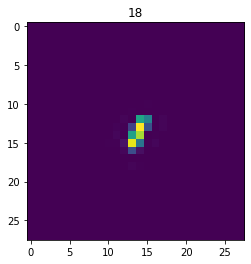

In [ ]:
# Load the model and the data.
model = fedjax.models.emnist.create_conv_model(only_digits=False)
train, test = fedjax.datasets.emnist.load_data(only_digits=False,
                                               cache_dir='/tmp/emnist_data')
# Print a single client data to verify data is loaded.
example_client_id = 'f0000_14'
single_client_data = train.create_tf_dataset_for_client(example_client_id)
numpy_client_data = list(single_client_data.as_numpy_iterator())
pixels = numpy_client_data[0]['x']
label = numpy_client_data[0]['y']
plt.title(f'{label}')
plt.imshow(pixels.reshape(28, 28))

In [ ]:
# Define federated algorithm.


Model = fedjax.Model
Params = fedjax.Params
OptState = fedjax.OptState
Optimizer = fedjax.Optimizer

class FedAvgServerState(NamedTuple):
  params: Params
  opt_state: OptState
  aggregator_state: Any

class SimpleFedAvg():

  def __init__(self,
               model: Model,
               client_optimizer: Optimizer,
               server_optimizer: Optimizer,
               client_batch_size: int,
               num_levels: int):
    self.model = model
    self.client_optimizer = client_optimizer
    self.server_optimizer = server_optimizer
    self.client_batch_size = client_batch_size
    self.aggregator = compression.uniform_stochastic_quantizer(
        num_levels=num_levels)
    
  
  def client_update(self, server_state, client_data):
    params = server_state.params
    opt_state = self.client_optimizer.init_fn(params)
    num_examples = 0.
    rng_seq = fedjax.PRNGSequence(0)
    for batch, rng in zip(client_data, rng_seq):
      backward_pass_output = self.model.backward_pass(params, batch, rng)
      grads = backward_pass_output.grads
      updates, opt_state = self.client_optimizer.update_fn(grads, opt_state)
      params = self.client_optimizer.apply_updates(updates, params)
      num_examples += backward_pass_output.num_examples
    delta = jax.tree_util.tree_multimap(lambda a, b: a - b, 
                                        server_state.params,
                                        params)
    return delta, num_examples

  def server_update(self, server_state, client_outputs):
    rng_seq = fedjax.PRNGSequence(0)
    weighted_averaged_delta, new_aggregator_state = self.aggregator.apply(
        client_outputs, rng_seq, server_state.aggregator_state)
    updates, opt_state = server_optimizer.update_fn(weighted_averaged_delta,
                                                    server_state.opt_state)
    params = server_optimizer.apply_updates(updates, server_state.params)
    return FedAvgServerState(params, opt_state, new_aggregator_state)

  def init(self, rng):
    params = model.init_params(rng)
    opt_state = self.server_optimizer.init_fn(params)
    aggregator_state = self.aggregator.init()
    return FedAvgServerState(params, opt_state, aggregator_state)

  def run_one_round(self, server_state, client_ids):
    client_outputs = []
    for client_id in client_ids:
      client_data = train.create_tf_dataset_for_client(client_id)
      client_data = client_data.batch(self.client_batch_size)
      client_data = client_data.as_numpy_iterator()
      client_outputs.append(self.client_update(server_state, client_data))
    return self.server_update(server_state, client_outputs)

In [ ]:
# Run federated algorithm.
# The hyper-parameters here is not the state of the art. It achieves a
# global test accuracy as follows
# num_levels, server_learning_rate, test_accuracy 
# 256, 1.0, 84.5%
# 16, 0.01, 59.8%
# 2, 0.001, 23.6%
num_rounds = 1000
num_clients_per_round = 10
rng = 0
client_batch_size = 10
# num_levels is the number levels of quantization. The number of bits
# used is log_2(num_levels).
num_levels = 2
client_optimizer = fedjax.get_optimizer(fedjax.OptimizerName.SGD,
                                        learning_rate=0.1)
server_optimizer = fedjax.get_optimizer(fedjax.OptimizerName.SGD,
                                        learning_rate=0.001)

algorithm = SimpleFedAvg(model, client_optimizer,
                         server_optimizer, client_batch_size, num_levels)
start = time.time()
server_state = algorithm.init(rng)
np.random.seed(0)
for round_num in range(1, num_rounds + 1):
  client_ids = np.random.choice(train.client_ids, 
                                size=num_clients_per_round,
                                replace=False)
  server_state = algorithm.run_one_round(server_state, client_ids)
  if round_num % 25 == 0:
    print('round_num: {}, mean_round_duration: {} sec'.format(
        round_num, (time.time() - start)/25))
    start = time.time() 
global_params = server_state.params

round_num: 25, mean_round_duration: 1.525042886734009 sec
round_num: 50, mean_round_duration: 1.3385536766052246 sec
round_num: 75, mean_round_duration: 1.3813207530975342 sec
round_num: 100, mean_round_duration: 1.3918876075744628 sec
round_num: 125, mean_round_duration: 1.556784725189209 sec
round_num: 150, mean_round_duration: 1.4496421813964844 sec
round_num: 175, mean_round_duration: 1.5728481101989746 sec
round_num: 200, mean_round_duration: 1.3059182453155518 sec
round_num: 225, mean_round_duration: 1.3199282741546632 sec
round_num: 250, mean_round_duration: 1.3994597625732421 sec
round_num: 275, mean_round_duration: 1.3082616424560547 sec
round_num: 300, mean_round_duration: 1.4410183334350586 sec
round_num: 325, mean_round_duration: 1.3942552280426026 sec
round_num: 350, mean_round_duration: 1.377430238723755 sec
round_num: 375, mean_round_duration: 1.5493021869659425 sec
round_num: 400, mean_round_duration: 1.4330929279327393 sec
round_num: 425, mean_round_duration: 1.3457640

In [ ]:
# Evaluate the global model
hparams = fedjax.ClientDataHParams(batch_size=10, num_epochs=1) 
all_metrics = fedjax.evaluate_multiple_clients(federated_data=test, 
                                               client_ids=test.client_ids,
                                               model=model,
                                               params=global_params,
                                               client_data_hparams=hparams)
all_metrics = list(all_metrics)
print(pd.DataFrame.from_records(all_metrics).mean())

loss             3.879802
regularizer      0.000000
num_examples    22.789118
accuracy         0.236352
dtype: float64
